In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
from covariance_generation import generate_galactocentric_covmat, transform_cov_cylindirical
import covariance_generation
from mcmc_plots import *
import data_analysis
import transformation_constants
from velocity_curve_plots import load_bin_settings
import helper_functions as helpfunc
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd
import pickle


In [24]:


# Eilers comp - z0=25 pc
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-16-12-31-44_48_EILERS_COMPARISON_w_cut_5'

# Eilers comp - z0=0 pc
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-04-25-15-23-53_48_EILERS_COMPARISON_w_cut_5_Z_0_CHECK'

paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']
bin_edges_r = bin_setup['bin_edges'][0][0]

1. bin_centers_r= [0.67717311 0.80029549 0.92341788 1.04654026 1.16966264 1.29278503
 1.41590741 1.5390298  1.66215218 1.78527456]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[0.61561192, 0.7387343 , 0.86185669, 0.98497907, 1.10810145,
        1.23122384, 1.35434622, 1.4774686 , 1.60059099, 1.72371337,
        1.84683575],
       [0.61561192, 0.7387343 , 0.86185669, 0.98497907, 1.10810145,
        1.23122384, 1.35434622, 1.4774686 , 1.60059099, 1.72371337,
        1.84683575]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1]
 [245.8]
 [  7.8]]
6. R_0= 8122
7. Z_0= 25
8. final_sample_size= (1598035, 16)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(0.6771731100714109, 1546.8745780308357), (0.8002954937207585, 1551.7836420468816), (0.9234178773701058, 1665.69443

Sampler shape: (8000, 48, 12)


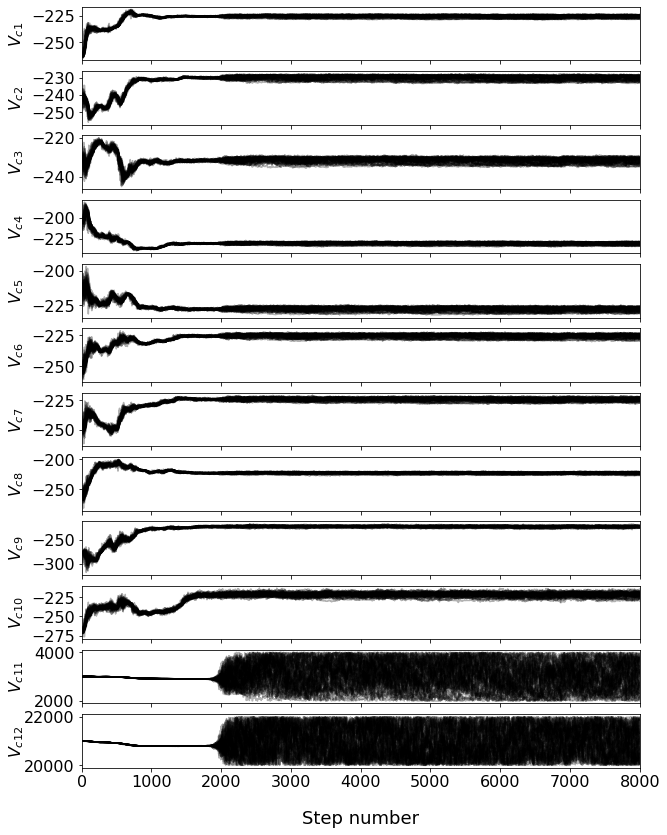

In [8]:
plot_walkers(samplers[1], 0)

In [9]:
# Gets V_c mean values and errors
burnin = 5000
path = samplers[0]
reader = emcee.backends.HDFBackend(path, read_only=True)
samples_data = reader.get_chain(discard=burnin)
flatchain = reader.get_chain(flat=True, discard = burnin)

bin_velocities = []
ndim = samples_data.shape[2]

for i in range(ndim):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
    bin_velocities.append((v_mean, v_sub, v_sup))

velocity_array_z25 = np.array(bin_velocities)

burnin = 3000
path = samplers[1]
reader = emcee.backends.HDFBackend(path, read_only=True)
samples_data = reader.get_chain(discard=burnin)
flatchain = reader.get_chain(flat=True, discard = burnin)

bin_velocities = []
ndim = samples_data.shape[2]

for i in range(ndim):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
    bin_velocities.append((v_mean, v_sub, v_sup))
    
velocity_array_z0 = np.array(bin_velocities)

In [19]:
v_diff = velocity_array_z25[0:10, 0] - velocity_array_z0[0:10, 0]
np.abs(v_diff)

array([0.1642335 , 0.12531747, 0.11204277, 0.15497386, 0.16467586,
       0.12396365, 0.1639622 , 0.5653955 , 0.38473988, 1.02347007])

In [28]:
# Rotation Curve Plotting Function

def plot_rotation_curve(mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False,
                        is_last_merged=False):


    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    
    bin_setup = load_bin_settings(mcmc_runs[0], is_print=False)
    bin_centers_r = bin_setup['bin_centers_r']*8122

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    mcmc_fmts = ['o', 'o']
    for i_path, path in enumerate(mcmc_runs):

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-100, 100, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt=mcmc_fmts[i_path], 
                    c=colors[i_path], 
                    label=labels[i_path], 
                    markersize = 8)

    plt.xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.xaxis.set_major_locator(MultipleLocator(1e3))
    ax.yaxis.set_major_locator(MultipleLocator(5))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    if(display_bin_edges):
        if(is_last_merged):
            # Remove middle boundary
            bin_edges_r = np.delete(bin_edges_r, -2)
        ax.vlines(bin_edges_r, 205, 255, linestyles='dashed', alpha=0.5, colors='grey')   
        #x_ticks = np.round(bin_edges_r)
        #ax.set_xticks(x_ticks)

    lit_fmts = ['+', 'x', '^', 'v', '.']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'grey']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 16]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if(key == 'Eilers et al. 2018'):
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            plt.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key, alpha=0.6)

    plt.legend(prop={'size': 9})

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    plt.xlim(4000, 16000)
    plt.rcParams["axes.grid"] = False




def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

R, v_c, sig-, sig+
5.5 225.2 1.9 1.1
6.5 229.9 1.9 1.1
7.5 231.4 2.0 1.2
8.5 230.0 2.1 1.3
9.5 227.5 2.1 1.3
10.5 225.5 2.3 1.4
11.5 224.2 2.1 1.3
12.5 223.2 1.9 1.3
13.5 221.4 2.1 1.6
14.5 222.2 3.7 2.9
(10,)
(10,)
R, v_c, sig-, sig+
5.5 225.0 1.8 1.1
6.5 229.8 1.8 1.1
7.5 231.3 1.9 1.1
8.5 229.8 2.0 1.2
9.5 227.4 2.1 1.3
10.5 225.3 2.2 1.3
11.5 224.0 2.0 1.3
12.5 222.6 1.8 1.3
13.5 221.0 2.2 1.5
14.5 221.2 3.3 2.7
(10,)
(10,)


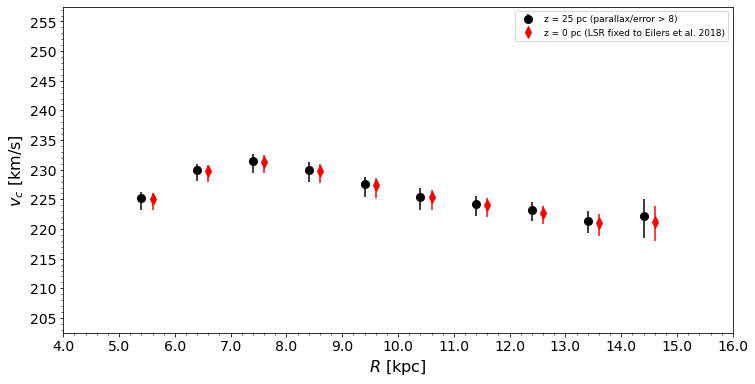

In [30]:
extra_dims = [2, 2]

result_name_1 = 'z = 25 pc (parallax/error > 8)'
result_name_2 = 'z = 0 pc (LSR fixed to Eilers et al. 2018)'
plot_rotation_curve([paths[0], paths[1]], 
                    [result_name_1, result_name_2],
                    [5000, 3000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True,
                    is_last_merged=False)